# **Previsão do Preço das Ações da Netflix com Redes Neurais**

**Objetivo**

* Construir um modelo neural capaz de prever o preço das ações da Netflix

### **1. Introdução**

<p align="justify">
No mundo atual, a previsão do mercado de ações é uma área de pesquisa crucial e a aplicação do aprendizado de máquina para esse propósito tornou-se uma ferramenta valiosa. Este projeto tem como objetivo criar um modelo de machine learning simples e intuitivo para prever o preço de fechamento das ações da Netflix. A Netflix é uma das principais empresas de streaming de conteúdo do mundo, e a previsão de seus preços de ações é de grande interesse para investidores, traders e analistas financeiros.

<p align="justify">
A escolha de criar um modelo de previsão de preços de ações da Netflix é relevante por várias razões. Primeiramente, as oscilações nos preços das ações podem ser influenciadas por uma ampla gama de fatores, incluindo o desempenho financeiro da empresa, notícias do setor, eventos econômicos globais e até mesmo a popularidade de seus programas e filmes. Portanto, essa tarefa é desafiadora e oferece uma oportunidade significativa para explorar a capacidade do aprendizado de máquina em lidar com dados financeiros complexos e voláteis.

In [1]:
# Carregando bibliotecas

import datetime
import numpy as np
import pandas as pd
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Coletando dados

## Definindo parâmetros para a coleta dos dados
today = date.today()                         # Data de Hoje

data = date.today() - timedelta(days = 1825) # Coletando dados dos últimos 1825 dias (5 anos) a partir da data de hoje
data = data.strftime("%Y-%m-%d")             # Pré-Processando o formato da data

data_inicial = data                          # Definindo a data inicial da coleta dos dados
data_final = today.strftime("%Y-%m-%d")      # Definindo a data final da coleta dos dados

## Coletando os dados
dados = yf.download('NFLX',
                    start = data_inicial,
                    end = data_final,
                    progress = False)

## Pré-Processando os dados
dados["Date"] = dados.index
dados = dados[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
dados.reset_index(drop = True, inplace = True)

## Visualizando base de dados
dados.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-31,297.769989,311.500000,295.049988,301.779999,301.779999,20360300
1,2018-11-01,304.589996,318.450012,296.670013,317.380005,317.380005,15121500
2,2018-11-02,318.000000,321.880005,308.329987,309.100006,309.100006,13404600
3,2018-11-05,311.100006,317.529999,303.739990,315.440002,315.440002,10283000
4,2018-11-06,314.760010,320.220001,305.299988,310.839996,310.839996,9710400


### **2. Análise Exploratória de Dados**

In [3]:
sns.set()

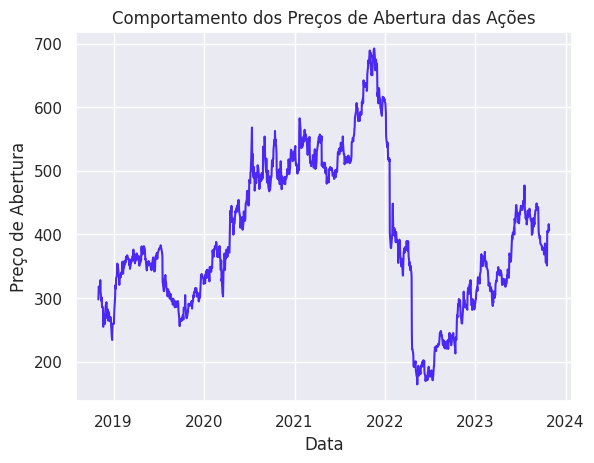

In [4]:
# Gráfico 1: Verificando comportamento dos preços de abertura das ações

## Configurando gráfico
sns.lineplot(x = 'Date',
             y = 'Open',
             color = '#4c28f5',
             data = dados)

## Definindo labels do gráfico
plt.xlabel('Data')
plt.ylabel('Preço de Abertura')
plt.title('Comportamento dos Preços de Abertura das Ações')

## Plotando gráfico
plt.show()

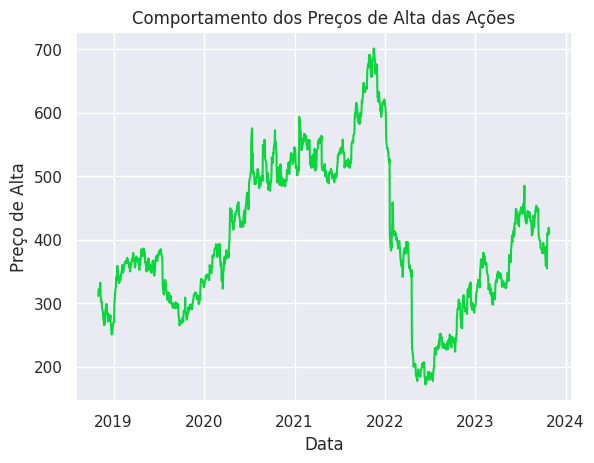

In [5]:
# Gráfico 2: Verificando comportamento dos preços de alta das ações

## Configurando gráfico
sns.lineplot(x = 'Date',
             y = 'High',
             color = '#08d83c',
             data = dados)

## Definindo labels do gráfico
plt.xlabel('Data')
plt.ylabel('Preço de Alta')
plt.title('Comportamento dos Preços de Alta das Ações')

## Plotando gráfico
plt.show()

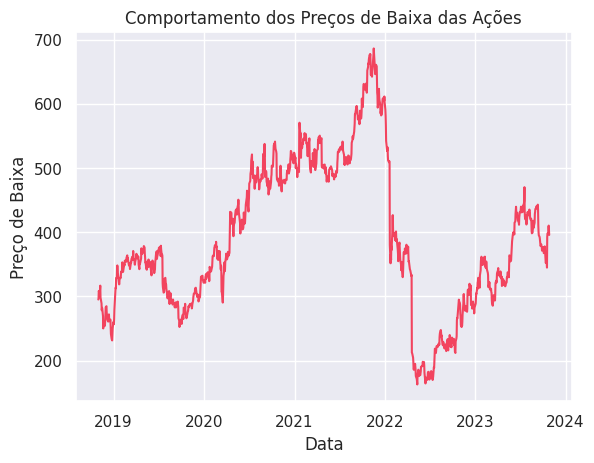

In [6]:
# Gráfico 3: Verificando comportamento dos preços de baixa das ações

## Configurando gráfico
sns.lineplot(x = 'Date',
             y = 'Low',
             color = '#f2445f',
             data = dados)

## Definindo labels
plt.xlabel('Data')
plt.ylabel('Preço de Baixa')
plt.title('Comportamento dos Preços de Baixa das Ações')

## Plotando gráfico
plt.show()

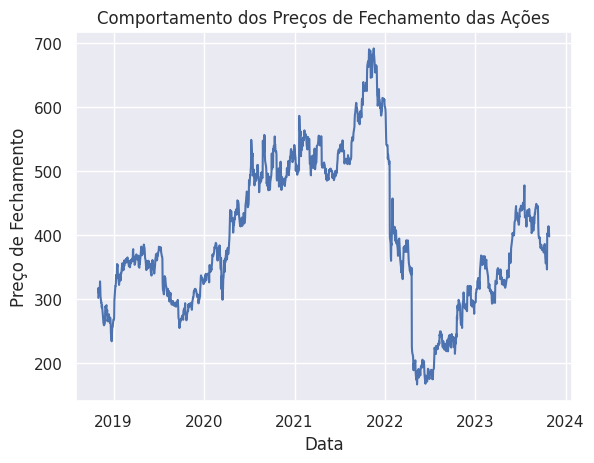

In [7]:
# Gráfico 4: verificando comportamento dos preços de fechamento das ações

## Configurando gráfico
sns.lineplot(x = 'Date',
             y = 'Close',
             data = dados)

## Definindo labels dos gráficos
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Comportamento dos Preços de Fechamento das Ações')

## Plotando gráfico
plt.show()

In [8]:
# Gráfico 5: Visualizando comportamento do preço das ao longo dos anos

figure = go.Figure(data=[go.Candlestick(x = dados["Date"],
                                        open = dados["Open"],
                                        high = dados["High"],
                                        low = dados["Low"],
                                        close = dados["Close"])])

figure.update_layout(title = "Análise dos Preços das Ações da Netflix",
                     xaxis_rangeslider_visible = False,
                     title_x = 0.5)
figure.show()

In [9]:
# Informações sobre o dataset

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1256 non-null   datetime64[ns]
 1   Open       1256 non-null   float64       
 2   High       1256 non-null   float64       
 3   Low        1256 non-null   float64       
 4   Close      1256 non-null   float64       
 5   Adj Close  1256 non-null   float64       
 6   Volume     1256 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.8 KB


In [10]:
# Descritiva do dataset

dados.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03
mean,395.774872,401.991616,389.450335,395.833750,395.833750,7.485533e+06
std,116.922374,117.591519,115.816820,116.607946,116.607946,6.484568e+06
min,163.960007,172.059998,162.710007,166.369995,166.369995,1.144000e+06
25%,310.505005,316.412491,304.732498,311.477501,311.477501,4.198650e+06
50%,371.729996,377.744995,364.895004,371.055008,371.055008,5.884750e+06
75%,495.047501,503.104996,487.897499,494.677505,494.677505,8.653425e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,1.333875e+08


### **3.Pré-Processamento de Dados**

In [11]:
# Separando os dados em previsores e target

previsores = dados[['Open', 'High', 'Low', 'Volume']]
target = dados[['Close']]

In [12]:
# Transformando dados em um Array NumPy

previsores = previsores.to_numpy()
target = target.to_numpy()

In [13]:
# Alterando forma dos dados da variável target

target = target.reshape(-1, 1)

In [14]:
# Dividindo os dados em treino e teste

X_treino, X_teste, y_treino, y_teste = train_test_split(previsores,
                                                        target,
                                                        test_size = 0.3,
                                                        random_state = 0)

In [15]:
# Verificando distribuição dos dados

print(X_treino.shape)
print(y_treino.shape)
print(X_teste.shape)
print(y_teste.shape)

(879, 4)
(879, 1)
(377, 4)
(377, 1)


### **4. Construindo Modelo**

In [16]:
# Camadas do modelo

modelo = Sequential()
modelo.add(LSTM(128, return_sequences = True, input_shape = (X_treino.shape[1], 1)))
modelo.add(LSTM(64, return_sequences = False))
modelo.add(Dense(25))
modelo.add(Dense(1))

In [17]:
# Resumo do modelo

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Instânciando o modelo

modelo.compile(optimizer = 'adam',
               loss = 'mean_squared_error')

In [19]:
# Treinando o modelo

modelo.fit(X_treino,
           y_treino,
           batch_size = 1,
           epochs = 30)

Epoch 1/30
879/879 [==============================] - 22s 15ms/step - loss: 37009.6367
Epoch 2/30
879/879 [==============================] - 6s 7ms/step - loss: 805.5848
Epoch 3/30
879/879 [==============================] - 7s 8ms/step - loss: 496.5981
Epoch 4/30
879/879 [==============================] - 6s 7ms/step - loss: 507.6302
Epoch 5/30
879/879 [==============================] - 7s 8ms/step - loss: 243.2670
Epoch 6/30
879/879 [==============================] - 6s 7ms/step - loss: 353.4242
Epoch 7/30
879/879 [==============================] - 7s 8ms/step - loss: 428.7125
Epoch 8/30
879/879 [==============================] - 6s 7ms/step - loss: 159.4727
Epoch 9/30
879/879 [==============================] - 7s 8ms/step - loss: 241.8917
Epoch 10/30
879/879 [==============================] - 6s 7ms/step - loss: 174.3389
Epoch 11/30
879/879 [==============================] - 7s 8ms/step - loss: 399.1031
Epoch 12/30
879/879 [==============================] - 7s 8ms/step - loss: 186.53

In [20]:
# Aplicando modelo treinado aos dados de teste

y_predito = modelo.predict(X_teste)

12/12 [==============================] - 1s 4ms/step


### **5. Avaliando e Testando o Modelo**

In [21]:
# Calculaando o erro médio quadrático (MSE)
mse = mean_squared_error(y_teste, y_predito)
mse

47.00800932031582

In [22]:
# Calculando o coeficiente de determinação (R²)
r2 = r2_score(y_teste, y_predito)
r2

0.9966789099579338

In [23]:
# Aplicando a novos dados

new_data = np.array([[401.970001, 427.700012, 398.200012, 20047500]])
modelo.predict(new_data)

1/1 [==============================] - 0s 126ms/step


array([[412.75156]], dtype=float32)

### **6. Considerações Finais**

<p align="justify">
Nesse estudo, o objetivo era criar um modelo de Machine Learning capaz de prever o preço de fechamento das ações da Netflix. Para isso, se fez uso da técnica de Redes Neurais, em particular, a LSTM.

<p align="justify">
Realizada todas as etapas de análise exploratória e pré-processamento dos dados, foi construido o modelo. Para prever o preço de fechamento das ações foi utilizado informações de preço de abertura, máximo, minimo e volume de ações comercializadas no dia.

<p align="justify">
Para análise do modelo construido foi usado as métricas MSE e R², que apresentaram resultados considerados bons. O MSE foi de 47, ou seja, em média, os dados previstos está distante do real 47 unidade (ou dólares, reais, euros, depende da moeda que está sendo comercializa as ações). Já o resultado do R² diz que 99% da variável target (Close) pode ser explicada pelas variáveis previsores (Open, High, Low e Volume).